In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor



C:\Users\vnuretdi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\vnuretdi\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import tensorflow as tf

In [39]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.optimizers import SGD

### Load the data

In [3]:
train = pd.read_csv('training.csv')
test=pd.read_csv('test.csv')

In [9]:
ids=pd.read_csv("IdLookupTable.csv")

In [10]:
sample=pd.read_csv("SampleSubmission.csv")

### Transform the data for the Tensorflow model

#### Extract values with full data on facepoints to be used for the first train iteration

In [11]:
df=train.dropna()
df.shape

(2140, 31)

#### Create X and Y values which will be used as Tensorflow input data. Normalize both X and Y

In [12]:
image = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
X = np.vstack(image.values) / 255 
X = X.astype(np.float64)

In [13]:
Y = df.drop(['Image'], axis=1).values
Y = (Y - 48) / 48  
Y = Y.astype(np.float64)

### Add new observations by flipping the images horizontally

In [14]:
from copy import copy, deepcopy

X1=deepcopy(X)

for i in range(len(X1)):
    a1=np.reshape(X1[i],(96,96))
    a1=np.flip(a1, 1)
    a1=np.reshape(a1,(96*96,))
    X1[i]=a1

Y1=deepcopy(Y)

for i in range(len(Y1)):
    Y1[i][0::2]=-Y1[i][0::2]
    Y1[i]=Y1[i][[2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]]

In [15]:
### extend X and Y inputs to the newly obtained observations
X_ext=np.append(X, X1, axis=0)
Y_ext=np.append(Y, Y1, axis=0)

In [22]:
names=list(df.columns[:-1])

In [24]:
X_ext.shape

(4280, 9216)

In [36]:
X_ext=np.reshape(X_ext, (-1,96,96, 1))

In [37]:
print(X_ext.shape, Y_ext.shape)

(4280, 96, 96, 1) (4280, 30)


### Build first CNN model based on 4280 complete observations

- InputLayer            (None, 1, 96, 96)       produces    9216 outputs
- Conv2DCCLayer         (None, 32, 94, 94)      produces  282752 outputs
- MaxPool2DCCLayer      (None, 32, 47, 47)      produces   70688 outputs
- Conv2DCCLayer         (None, 64, 46, 46)      produces  135424 outputs
- MaxPool2DCCLayer      (None, 64, 23, 23)      produces   33856 outputs
- Conv2DCCLayer         (None, 128, 22, 22)     produces   61952 outputs
- MaxPool2DCCLayer      (None, 128, 11, 11)     produces   15488 outputs
- DenseLayer            (None, 500)             produces     500 outputs
- DenseLayer            (None, 500)             produces     500 outputs
- DenseLayer            (None, 30)              produces      30 outputs

In [53]:
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout

def SimpleCNN(withDropout=False):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''

    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (96, 96, 1), \
                     activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(filters = 64, kernel_size = (2, 2),  \
                     activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(filters = 128, kernel_size = (2, 2),  \
                     activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))   
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500, activation='relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500, activation='relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(30))
    sgd = SGD(lr=0.01,momentum = 0.9,nesterov=True)
    model.compile(loss="mean_squared_error",optimizer=sgd)
    return(model)

In [54]:
%%time
model = SimpleCNN()

hist = model.fit(X_ext, Y_ext, nb_epoch=1000, validation_split=0.2, verbose=False)

C:\Users\vnuretdi\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


KeyboardInterrupt: 

In [1158]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [1151]:
sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.15393060202290462

In [1160]:
for i in range(100):
    sess.run(train_step, feed_dict={x: X_ext, y: Y_ext})

In [1161]:
sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.00458644798642958

## Use the first model to complete the observations with NA's

In [1181]:
incomplete=train[train.isnull().any(axis=1)]

In [1182]:
incomplete.shape

(4909, 31)

In [ ]:
image_incomp=incomplete['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

In [824]:
X_incomp=np.vstack(image_incomp.values) / 255
X_incomp = X_incomp.astype(np.float64)

In [1183]:
Y_incomp=incomplete.drop(['Image'], axis=1).values
Y_incomp=(Y_incomp-48)/48
Y_incomp=Y_incomp.astype(np.float64)

In [1185]:
print(X_incomp.shape, Y_incomp.shape)

(4909, 9216) (4909, 30)


In [1163]:
results=sess.run(yhat, feed_dict={x: X_incomp})

### Let's look at a few examples on how the incomplete facepoint data would be completed based on the model
(blue are real available values, red are calcualted values)

In [1186]:
def getimage(k):
    a=np.reshape(X_incomp[k],(96,96))
    plt.imshow(a)
    for i in range(15):
        y_axis=int((results[k][2*i+1]+1)*48)
        x_axis=int((results[k][2*i]+1)*48)
        plt.scatter(x_axis, y_axis, s=5, c='red', marker='o')
        plt.scatter(np.nan_to_num(Y_incomp[k][2*i]+1)*48, np.nan_to_num(Y_incomp[k][2*i+1]+1)*48, s=5, c='blue', marker='o')
    plt.show()

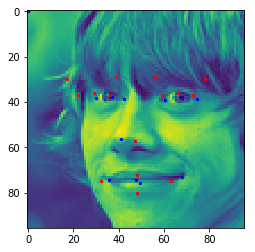

In [1187]:
getimage(90)

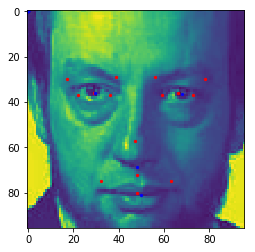

In [1189]:
getimage(390)

### Let's complete Y values and add new observations

In [1193]:
for i in range(len(Y_incomp)):
    ind=np.argwhere(np.isnan(Y_incomp[i]))
    Y_incomp[i][ind]=results[i][ind]

In [1196]:
np.argwhere(np.isnan(Y_incomp))

array([], shape=(0, 2), dtype=int64)

In [1197]:
X_ext=np.append(X_ext, X_incomp, axis=0)
Y_ext=np.append(Y_ext, Y_incomp, axis=0)

print(X_ext.shape, Y_ext.shape)

(9189, 9216) (9189, 30)


## Build Tensorflow model based on 9189 observations

In [1198]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.14956627830429972

In [1199]:
for i in range(100):
    sess.run(train_step, feed_dict={x: X_ext, y: Y_ext})

sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.0037533649685022406

## Transform test data and build the facepoints

In [1200]:
image_test=test.Image.apply(lambda im: np.fromstring(im, sep = ' '))
X_test=np.vstack(image_test.values) / 255
X_test = X_test.astype(np.float64)

### Review a couple of test examples

In [1201]:
results=sess.run(yhat, feed_dict={x: X_test})

In [1202]:
def getimage(k):
    a=np.reshape(X_test[k],(96,96))
    plt.imshow(a)
    for i in range(15):
        y_axis=int((results[k][2*i+1]+1)*48)
        x_axis=int((results[k][2*i]+1)*48)
        plt.scatter(x_axis, y_axis, s=5, c='red', marker='o')
    plt.show()

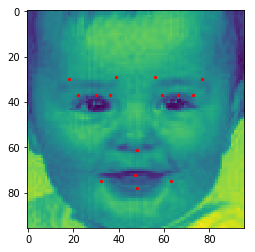

In [1203]:
getimage(930)

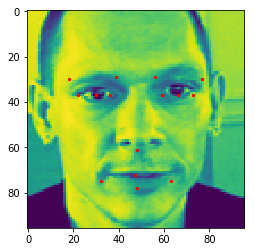

In [1205]:
getimage(230)

#### Create the submission file based on the RF model prediction results

In [1094]:
ids.ImageId-=1
ids.index=ids.ImageId

In [706]:
names=list(train.columns[:-1])

In [1095]:
ids.head()

,RowId,ImageId,FeatureName,Location
ImageId,,,,
0,1,0,left_eye_center_x,NaN
0,2,0,left_eye_center_y,NaN
0,3,0,right_eye_center_x,NaN
0,4,0,right_eye_center_y,NaN
0,5,0,left_eye_inner_corner_x,NaN


In [1128]:
for k in range(1783):
    if len(ids.loc[ids.ImageId==k])==30:
        ids.loc[ids.ImageId==k, "Location"]=(results[k]+1)*48
    else:
        present=[i for i in range(30) if names[i] in ids.loc[ids.ImageId==k, "FeatureName"].values]
        ids.loc[ids.ImageId==k, "Location"]=(results[k][present]+1)*48

In [1129]:
results.shape

(1783, 30)

In [1130]:
submission=ids[["RowId","Location"]]

In [1131]:
submission.to_csv("submission.csv", index=False)

In [1132]:
submission.shape

(27124, 2)